In [14]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

# Initialize BigQuery client with your Google project ID
client = bigquery.Client(project='geometric-shine-469609-f8')

query = """
SELECT
  event_date,
  event_name,
  user_pseudo_id,
  device.category AS device_category,
  device.operating_system,
  device.web_info.browser,
  geo.country,
  geo.city,
  traffic_source.source,
  traffic_source.medium,
  traffic_source.name AS campaign_name,
  ecommerce.transaction_id,
  ecommerce.purchase_revenue,
  ecommerce.purchase_revenue_in_usd,
  ecommerce.total_item_quantity,
  event_timestamp
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE _TABLE_SUFFIX BETWEEN '20201101' AND '20201231'
  AND event_name IN (
    'purchase',
    'first_visit',
    'page_view',
    'session_start',
    'user_engagement'
  )
ORDER BY event_timestamp
"""

# Run the query and get the results in a DataFrame
df = client.query(query).result().to_dataframe(create_bqstorage_client=True)

# Convert event_timestamp to datetime
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='us')

# Save the DataFrame as CSV in Colab environment
csv_filename = "merchandise_store_full_data.csv"
df.to_csv(csv_filename, index=False)

print(f"Data downloaded and saved as '{"merchandise_store_full_data.csv"}' in Colab environment. Total rows: {len(df)}")


Data downloaded and saved as 'merchandise_store_full_data.csv' in Colab environment. Total rows: 2151546


In [15]:
# --- Step 2.1: Load Data ---
import pandas as pd

csv_filename = "merchandise_store_full_data.csv"
df = pd.read_csv(csv_filename)

print("## Step 2.1: Load Data")
print(f"Data loaded from '{csv_filename}'. Total rows: {len(df)}, columns: {len(df.columns)}")


print(f"\nData types:")
print(df.dtypes)

print(f"\n✅ Data loading complete! Moving to next step...")


/tmp/ipython-input-3497896867.py:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_filename)


## Step 2.1: Load Data
Data loaded from 'merchandise_store_full_data.csv'. Total rows: 2151546, columns: 16

Data types:
event_date                   int64
event_name                  object
user_pseudo_id             float64
device_category             object
operating_system            object
browser                     object
country                     object
city                        object
source                      object
medium                      object
campaign_name               object
transaction_id              object
purchase_revenue           float64
purchase_revenue_in_usd    float64
total_item_quantity        float64
event_timestamp             object
dtype: object

✅ Data loading complete! Moving to next step...


Why do we have so many missing values in purchase fields? Answer: Because most GA4 events are NOT purchases! Only purchase events will have transaction_id and revenue data.

In [16]:
# --- Step 2.2: Data Overview ---
print("## Step 2.2: Data Overview")
print("\nColumns:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())


## Step 2.2: Data Overview

Columns:
['event_date', 'event_name', 'user_pseudo_id', 'device_category', 'operating_system', 'browser', 'country', 'city', 'source', 'medium', 'campaign_name', 'transaction_id', 'purchase_revenue', 'purchase_revenue_in_usd', 'total_item_quantity', 'event_timestamp']

First 5 rows:
   event_date     event_name  user_pseudo_id device_category operating_system  \
0    20201101    first_visit    8.202397e+07         desktop        Macintosh   
1    20201101      page_view    8.202397e+07         desktop        Macintosh   
2    20201101  session_start    8.202397e+07         desktop        Macintosh   
3    20201101      page_view    7.754124e+06          mobile              Web   
4    20201101  session_start    7.754124e+06          mobile              Web   

   browser        country       city    source  medium campaign_name  \
0   Chrome         Canada    Toronto  (direct)  (none)      (direct)   
1   Chrome         Canada    Toronto  (direct)  (none)   

In [17]:
#describe statistics
print(df.describe().T)


                             count          mean           std           min  \
event_date               2151546.0  2.020117e+07  4.937226e+01  2.020110e+07   
user_pseudo_id           2151546.0  2.601981e+08  1.175938e+09  1.000300e+06   
purchase_revenue            4338.0  7.026625e+01  8.081102e+01  1.000000e+00   
purchase_revenue_in_usd     4488.0  6.791778e+01  8.044655e+01  0.000000e+00   
total_item_quantity         4338.0  4.438681e+00  9.930101e+00  1.000000e+00   

                                  25%           50%           75%  \
event_date               2.020112e+07  2.020120e+07  2.020121e+07   
user_pseudo_id           5.889911e+06  2.294114e+07  6.160978e+07   
purchase_revenue         2.800000e+01  4.800000e+01  8.400000e+01   
purchase_revenue_in_usd  2.500000e+01  4.600000e+01  8.100000e+01   
total_item_quantity      1.000000e+00  2.000000e+00  5.000000e+00   

                                  max  
event_date               2.020123e+07  
user_pseudo_id          

In [18]:
print("## Step 2.3: Data Types and Non-Null Counts")
print(df.info())


## Step 2.3: Data Types and Non-Null Counts
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2151546 entries, 0 to 2151545
Data columns (total 16 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   event_date               int64  
 1   event_name               object 
 2   user_pseudo_id           float64
 3   device_category          object 
 4   operating_system         object 
 5   browser                  object 
 6   country                  object 
 7   city                     object 
 8   source                   object 
 9   medium                   object 
 10  campaign_name            object 
 11  transaction_id           object 
 12  purchase_revenue         float64
 13  purchase_revenue_in_usd  float64
 14  total_item_quantity      float64
 15  event_timestamp          object 
dtypes: float64(4), int64(1), object(11)
memory usage: 262.6+ MB
None


In [19]:
# --- Step 2.5: Missing Values Analysis ---
print("## Step 2.5: Missing Values per Column")
print(df.isna().sum())

## Step 2.5: Missing Values per Column
event_date                       0
event_name                       0
user_pseudo_id                   0
device_category                  0
operating_system                 0
browser                          0
country                          0
city                             0
source                           0
medium                           0
campaign_name                    0
transaction_id             2147081
purchase_revenue           2147208
purchase_revenue_in_usd    2147058
total_item_quantity        2147208
event_timestamp                  0
dtype: int64


In [20]:
# Cell 7: Event analysis
print("## Step 2.6: Event Distribution")
print(df['event_name'].value_counts())

## Step 2.6: Event Distribution
event_name
page_view          931424
user_engagement    808624
session_start      238421
first_visit        168589
purchase             4488
Name: count, dtype: int64


In [21]:
# Cell 8: Data Quality Summary
print("## Step 2.8: Phase 1 Data Quality Summary")
print("="*50)

# Key metrics for conversion analysis
total_events = len(df)
total_sessions = df[df['event_name'] == 'session_start'].shape[0]
total_purchases = df[df['event_name'] == 'purchase'].shape[0]
conversion_rate = (total_purchases / total_sessions) * 100

print(" Dataset Summary:")
print(f"Total events: {total_events:,}")
print(f"Total sessions: {total_sessions:,}")
print(f"Total purchases: {total_purchases:,}")
print(f"Session conversion rate: {conversion_rate:.2f}%")




## Step 2.8: Phase 1 Data Quality Summary
 Dataset Summary:
Total events: 2,151,546
Total sessions: 238,421
Total purchases: 4,488
Session conversion rate: 1.88%


In [22]:
# --- Phase 1.3: Data Cleaning (Complete) ---
print("## Phase 1.3: Complete Data Cleaning")

# Check for any duplicate rows in the entire dataset
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows:,}")

# Check for duplicate transaction IDs in purchase events
purchase_df = df[df['event_name'] == 'purchase']
duplicate_txns = purchase_df.duplicated(subset=['transaction_id'], keep=False)
print(f"Rows with duplicate transaction IDs: {duplicate_txns.sum():,}")

# Clean up data types for better analysis
print(f"\nCleaning data types...")
df['user_pseudo_id'] = df['user_pseudo_id'].astype(str)
df['event_date'] = df['event_date'].astype(str)
# Quick final data check
print(f"\n📊 Final Dataset After Cleaning:")
print(f"Shape: {df.shape}")
print(f"Data types look good: ✅")
print(f"Ready for feature engineering: ✅")

print(f"\n✅ Phase 1.3: Data Cleaning COMPLETE!")
print(f"🚀 Ready for Phase 1.4: Feature Engineering")

## Phase 1.3: Complete Data Cleaning
Total duplicate rows: 0
Rows with duplicate transaction IDs: 1,236

Cleaning data types...

📊 Final Dataset After Cleaning:
Shape: (2151546, 16)
Data types look good: ✅
Ready for feature engineering: ✅

✅ Phase 1.3: Data Cleaning COMPLETE!
🚀 Ready for Phase 1.4: Feature Engineering


# **Phase 1.4: Feature Engineering**

In [24]:
# --- Phase 1.4: Feature Engineering ---
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
print("## Phase 1.4: Feature Engineering")

# Create analysis-ready features
df['is_purchase'] = (df['event_name'] == 'purchase').astype(int)
df['hour'] = df['event_timestamp'].dt.hour
df['day_name'] = df['event_timestamp'].dt.day_name()
df['is_weekend'] = df['event_timestamp'].dt.weekday.isin([5, 6]).astype(int)

print("✅ Phase 1 COMPLETE - Ready for Phase 2!")


## Phase 1.4: Feature Engineering
✅ Phase 1 COMPLETE - Ready for Phase 2!


### **2.1 Conversion Baseline**



In [25]:
# Cell 11: Conversion Rate Baseline
print("## Phase 2.1: Conversion Rate Baseline")

# Calculate overall conversion rate
sessions = len(df[df['event_name'] == 'session_start'])
purchases = len(df[df['event_name'] == 'purchase'])
conversion_rate = (purchases / sessions) * 100

print(f"Sessions: {sessions:,}")
print(f"Purchases: {purchases:,}")
print(f"Conversion rate: {conversion_rate:.2f}%")

# Quick check - what's our target?
target = 2.50
gap = target - conversion_rate
print(f"Target: {target}%")
print(f"Need to improve by: {gap:.2f} percentage points")

print("✅ Baseline done - let's see what affects conversion rates")


## Phase 2.1: Conversion Rate Baseline
Sessions: 238,421
Purchases: 4,488
Conversion rate: 1.88%
Target: 2.5%
Need to improve by: 0.62 percentage points
✅ Baseline done - let's see what affects conversion rates


**Cell 12: Traffic Source Analysis**

In [26]:
# Cell 12: Traffic Source Performance
print("## Phase 2.2: Traffic Source Analysis")

# Group by traffic source and calculate conversion rates
source_performance = df.groupby('source').agg({
    'event_name': 'count',
    'is_purchase': 'sum'
}).rename(columns={'event_name': 'total_events', 'is_purchase': 'purchases'})

# Calculate conversion rates by source
source_performance['conversion_rate'] = (source_performance['purchases'] /
                                       source_performance['total_events'] * 100).round(3)

# Sort by conversion rate
source_performance = source_performance.sort_values('conversion_rate', ascending=False)

print("Traffic Source Performance:")
print(source_performance)

# Quick insights
best_source = source_performance.index[0]
worst_source = source_performance.index[-1]
print(f"\nBest performing source: {best_source}")
print(f"Worst performing source: {worst_source}")

print("✅ Now we know which traffic sources work best!")


## Phase 2.2: Traffic Source Analysis
Traffic Source Performance:
                                 total_events  purchases  conversion_rate
source                                                                   
(data deleted)                         148657        673            0.453
shop.googlemerchandisestore.com        179678        536            0.298
(direct)                               495346        982            0.198
<Other>                                568994       1025            0.180
google                                 758871       1272            0.168

Best performing source: (data deleted)
Worst performing source: google
✅ Now we know which traffic sources work best!


# **🎯 Key Findings**
Surprising Results:

- (data deleted) has the highest conversion rate at 0.453% - interesting!

- Google traffic converts worst at only 0.168% - this is concerning

- Direct traffic performs better than Google at 0.198%

- Shop.googlemerchandisestore.com does well at 0.298%

# **Cell 13: Device Performance Analysis**

In [27]:
# Cell 13: Device Category Performance
print("## Phase 2.3: Device Performance")

# Analyze conversion by device category
device_performance = df.groupby('device_category').agg({
    'event_name': 'count',
    'is_purchase': 'sum'
}).rename(columns={'event_name': 'total_events', 'is_purchase': 'purchases'})

device_performance['conversion_rate'] = (device_performance['purchases'] /
                                        device_performance['total_events'] * 100).round(3)

print("Device Performance:")
print(device_performance.sort_values('conversion_rate', ascending=False))

# Quick mobile vs desktop check
mobile_conv = device_performance.loc['mobile', 'conversion_rate']
desktop_conv = device_performance.loc['desktop', 'conversion_rate']

print(f"\nMobile conversion: {mobile_conv}%")
print(f"Desktop conversion: {desktop_conv}%")

if mobile_conv < desktop_conv:
    print("🚨 Mobile conversion is lower - potential friction on mobile site")
else:
    print("✅ Mobile conversion looks good")

print("✅ Device analysis complete!")


## Phase 2.3: Device Performance
Device Performance:
                 total_events  purchases  conversion_rate
device_category                                          
mobile                 855195       1847            0.216
desktop               1249865       2559            0.205
tablet                  46486         82            0.176

Mobile conversion: 0.216%
Desktop conversion: 0.205%
✅ Mobile conversion looks good
✅ Device analysis complete!


# ** Device Performance Insights**


---


**Mobile Actually Outperforms Desktop:**

- Mobile: 0.216% conversion vs Desktop: 0.205%

- This is great news - no major mobile friction issues!

- Mobile users are slightly more likely to purchase

**Volume Distribution:**

- Desktop: 1.25M events (58% of traffic)

- Mobile: 855K events (40% of traffic)

- Tablet: 46K events (2% of traffic)

# ** Cell 14: Time Pattern Analysis**

In [28]:
# Cell 14: Time Pattern Analysis
print("## Phase 2.4: Time Patterns")

# Hour-based conversion analysis
hourly_performance = df.groupby('hour').agg({
    'event_name': 'count',
    'is_purchase': 'sum'
}).rename(columns={'event_name': 'total_events', 'is_purchase': 'purchases'})

hourly_performance['conversion_rate'] = (hourly_performance['purchases'] /
                                        hourly_performance['total_events'] * 100).round(3)

print("Top 5 hours for conversion:")
top_hours = hourly_performance.sort_values('conversion_rate', ascending=False).head()
print(top_hours)

# Weekend vs weekday
weekend_performance = df.groupby('is_weekend').agg({
    'event_name': 'count',
    'is_purchase': 'sum'
}).rename(columns={'event_name': 'total_events', 'is_purchase': 'purchases'})

weekend_performance['conversion_rate'] = (weekend_performance['purchases'] /
                                         weekend_performance['total_events'] * 100).round(3)

print(f"\nWeekend vs Weekday:")
print("Weekday conversion:", weekend_performance.loc[0, 'conversion_rate'], "%")
print("Weekend conversion:", weekend_performance.loc[1, 'conversion_rate'], "%")

print("✅ Time patterns analyzed!")


## Phase 2.4: Time Patterns
Top 5 hours for conversion:
      total_events  purchases  conversion_rate
hour                                          
5            90413        230            0.254
16           88825        221            0.249
22           88524        214            0.242
8            91060        205            0.225
6            90730        203            0.224

Weekend vs Weekday:
Weekday conversion: 0.217 %
Weekend conversion: 0.178 %
✅ Time patterns analyzed!


Business Implications
Campaign Timing Opportunities:

Focus ad spend during 5-6 AM and 4 PM hours

Weekday campaigns perform better than weekend ones

Consider email campaigns timed for early morning (5 AM)

User Behavior Insights:

People buy more during work days than leisure days

Early risers are high-converting customers

Evening shoppers (10 PM) also convert well

🎯 Action Items
Shift ad budgets to peak conversion hours (5 AM, 4 PM, 10 PM)

Reduce weekend spend, increase weekday focus

Test early morning email campaigns (5-6 AM sends)

# ** Cell 15: Geographic Analysis**

In [29]:
# Cell 15: Geographic Performance
print("## Phase 2.5: Geographic Analysis")

# Country-based conversion analysis
country_performance = df.groupby('country').agg({
    'event_name': 'count',
    'is_purchase': 'sum'
}).rename(columns={'event_name': 'total_events', 'is_purchase': 'purchases'})

country_performance['conversion_rate'] = (country_performance['purchases'] /
                                         country_performance['total_events'] * 100).round(3)

# Show top 10 countries by volume
top_countries = country_performance.sort_values('total_events', ascending=False).head(10)
print("Top 10 Countries by Traffic:")
print(top_countries)

# Show top 5 countries by conversion rate (min 1000 events)
high_converting = country_performance[country_performance['total_events'] >= 1000].sort_values('conversion_rate', ascending=False).head(5)
print(f"\nTop 5 Converting Countries (min 1000 events):")
print(high_converting)

print("✅ Geographic patterns identified!")


## Phase 2.5: Geographic Analysis
Top 10 Countries by Traffic:
                total_events  purchases  conversion_rate
country                                                 
United States         960227       1968            0.205
India                 196850        450            0.229
Canada                161073        355            0.220
United Kingdom         66960        142            0.212
France                 41093         96            0.234
Spain                  40558         92            0.227
China                  38007         74            0.195
Germany                36475         73            0.200
Taiwan                 36286         60            0.165
Italy                  31293         47            0.150

Top 5 Converting Countries (min 1000 events):
                    total_events  purchases  conversion_rate
country                                                     
Uruguay                     1052          6            0.570
Slovenia               

Business Opportunities
Immediate Actions:

Fix US market - Biggest traffic, biggest opportunity for improvement

Scale India success - High volume + good conversion = invest more

Learn from France - What makes French users convert better?

Investigate Italy/Taiwan - Why such low conversion rates?

Growth Markets:

Uruguay/Slovenia approach - Can we replicate their success?

Colombia expansion - Good volume + high conversion

🚨 Key Insight
The US market underperformance is a major opportunity - if we could get US conversion from 0.205% to just the overall average of 0.217%, that's +115 more purchases from existing traffic!

# **Cell 16: User Journey Analysis**

In [30]:
# Cell 16: User Journey Analysis
print("## Phase 2.6: User Journey Analysis")

# Create user journey by looking at event sequence per user
user_journey = df.groupby('user_pseudo_id').agg({
    'event_name': lambda x: ' → '.join(x.astype(str)),
    'is_purchase': 'max'
}).rename(columns={'event_name': 'journey', 'is_purchase': 'converted'})

# Look at common journey patterns for converters vs non-converters
converters = user_journey[user_journey['converted'] == 1]
non_converters = user_journey[user_journey['converted'] == 0]

print(f"Total users: {len(user_journey):,}")
print(f"Converters: {len(converters):,}")
print(f"Non-converters: {len(non_converters):,}")

# Sample conversion journeys
print(f"\nSample successful journeys:")
print(converters['journey'].head(3).tolist())

print(f"\nPhase 2 Business Analysis Complete!")
print(f"✅ Ready for Phase 3: Visualizations")


## Phase 2.6: User Journey Analysis
Total users: 179,058
Converters: 3,409
Non-converters: 175,649

Sample successful journeys:
['session_start → first_visit → page_view → user_engagement → page_view → user_engagement → user_engagement → page_view → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → user_engagement → page_view → purchase → user_engagement → user_engagement', 'session_start → page_view → first_visit → user_engagement → page_v

Phase 3-Chart 1

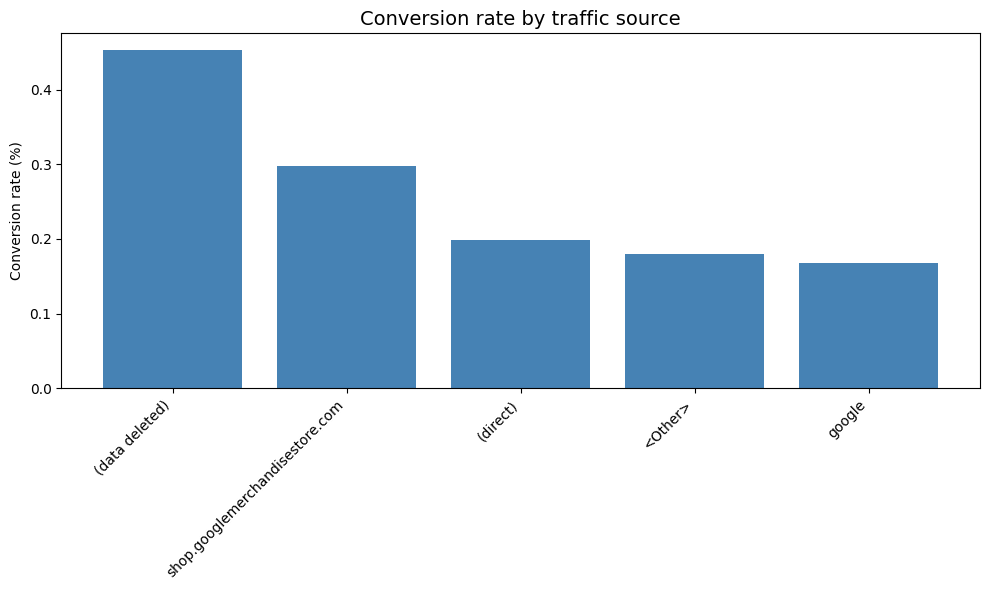

In [31]:
# Phase 3-Chart 1 – Conversion rate by traffic source
import matplotlib.pyplot as plt

# 1️⃣  aggregate
source_perf = (
    df.groupby("source")
      .agg(purchases=("is_purchase", "sum"),
           events=("event_name", "count"))
)
source_perf["conversion_rate"] = (
    source_perf["purchases"] / source_perf["events"] * 100
).round(3)
source_perf = source_perf.sort_values("conversion_rate", ascending=False)

# 2️⃣  plot
plt.figure(figsize=(10,6))
plt.bar(source_perf.index,
        source_perf["conversion_rate"],
        color="steelblue")
plt.title("Conversion rate by traffic source", fontsize=14)
plt.ylabel("Conversion rate (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1950721238.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_perf.index,


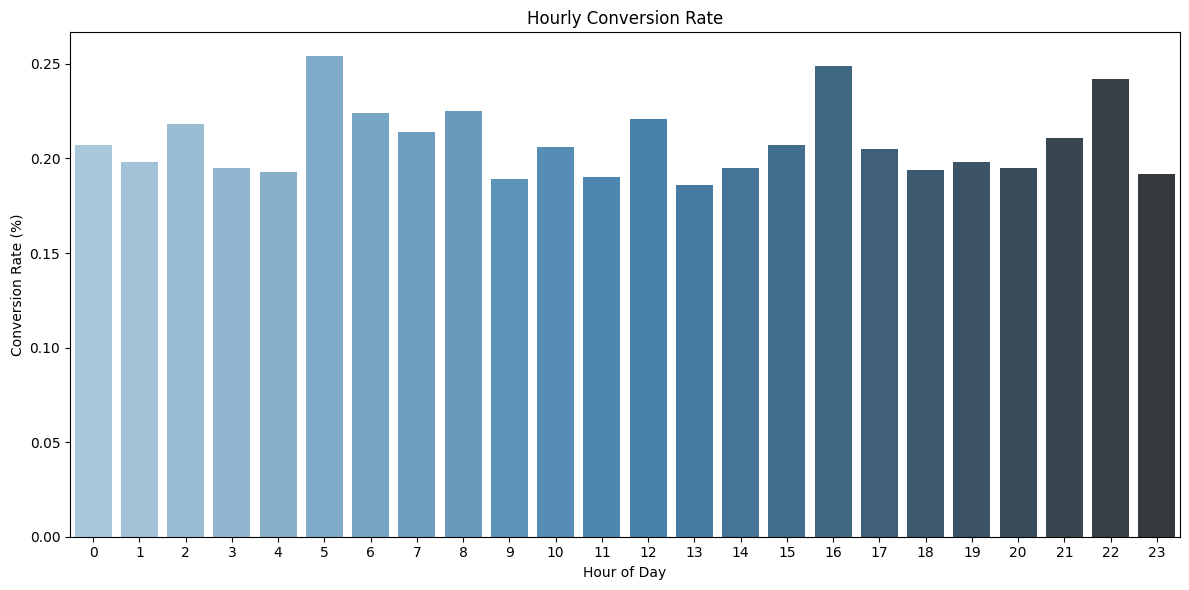

In [32]:
# Hourly conversion-rate bar chart  (Phase 3 – Chart 2)

import matplotlib.pyplot as plt
import seaborn as sns

# 1) build hourly conversion table
hourly_perf = (
    df.groupby('hour')
      .agg(purchases=('is_purchase', 'sum'),
           events=('event_name', 'count'))
)
hourly_perf['conversion_rate'] = (
    hourly_perf['purchases'] / hourly_perf['events'] * 100
).round(3)

# 2) plot
plt.figure(figsize=(12,6))
sns.barplot(x=hourly_perf.index,
            y=hourly_perf['conversion_rate'],
            palette='Blues_d')
plt.title('Hourly Conversion Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [33]:
# Sanity-check hourly volumes
hourly_counts     = df.groupby('hour').size()
hourly_purchases  = df[df['is_purchase'] == 1].groupby('hour').size()
hourly_conversion = (hourly_purchases / hourly_counts * 100).round(3)

print("Hourly event counts:\n", hourly_counts.head())
print("\nHourly purchase counts:\n", hourly_purchases.head())
print("\nHourly conversion (%):\n", hourly_conversion.head())


Hourly event counts:
 hour
0    88403
1    89005
2    89727
3    93385
4    90053
dtype: int64

Hourly purchase counts:
 hour
0    183
1    176
2    196
3    182
4    174
dtype: int64

Hourly conversion (%):
 hour
0    0.207
1    0.198
2    0.218
3    0.195
4    0.193
dtype: float64


/tmp/ipython-input-1995286272.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=device_perf.index,


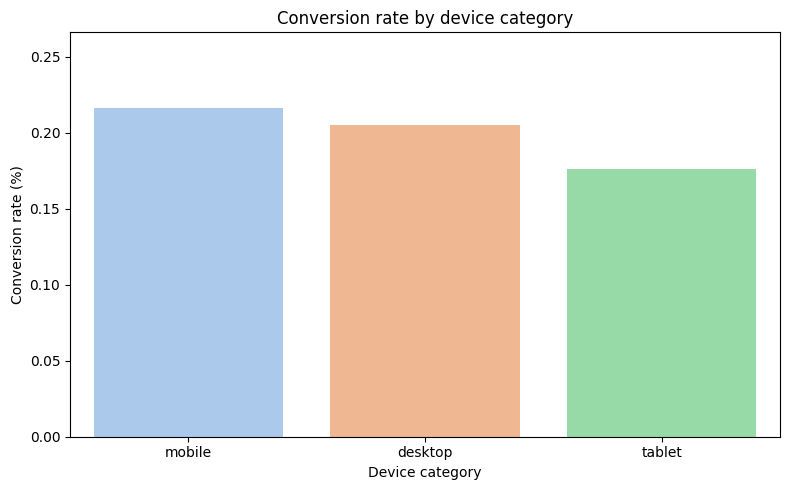

In [34]:
# Phase 3 – Chart 3: Conversion rate by device category
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣  aggregate
device_perf = (
    df.groupby('device_category')
      .agg(purchases=('is_purchase', 'sum'),
           events=('event_name', 'count'))
)
device_perf['conversion_rate'] = (
    device_perf['purchases'] / device_perf['events'] * 100
).round(3)
device_perf = device_perf.sort_values('conversion_rate', ascending=False)

# 2️⃣  plot
plt.figure(figsize=(8,5))
sns.barplot(x=device_perf.index,
            y=device_perf['conversion_rate'],
            palette='pastel')
plt.title('Conversion rate by device category')
plt.xlabel('Device category')
plt.ylabel('Conversion rate (%)')
plt.ylim(0, device_perf['conversion_rate'].max() + 0.05)   # a little headroom
plt.tight_layout()
plt.show()



In [36]:
# Phase 3 – Chart 4: Conversion rate by country (choropleth)
import plotly.express as px

# 1️⃣  aggregate
country_data = (
    df.groupby('country')
      .agg(purchases=('is_purchase', 'sum'),
           events=('event_name', 'count'))
      .reset_index()
)
country_data['conversion_rate'] = (
    country_data['purchases'] / country_data['events'] * 100
).round(3)

# keep countries with reasonable sample size
filtered = country_data[country_data['events'] > 1_000]

# 2️⃣  plot
fig = px.choropleth(filtered,
                    locations='country',
                    locationmode='country names',
                    color='conversion_rate',
                    color_continuous_scale='Viridis',
                    title='Conversion rate by country',
                    labels={'conversion_rate': 'Conversion rate (%)'})
fig.show()


In [37]:
# Basic Sankey diagram of common event flow
import plotly.graph_objects as go

# node labels
labels = ["session_start", "first_visit", "page_view",
          "user_engagement", "purchase"]

# minimal example flows (replace counts with your top path volumes)
links = dict(
    source=[0, 1, 2, 3],          # from session_start → … → purchase
    target=[1, 2, 3, 4],
    value =[1000, 800, 600, 400]  # example frequencies
)

fig = go.Figure(go.Sankey(
    node=dict(label=labels,
              pad=15, thickness=20,
              line=dict(width=0.5, color="black")),
    link=links
))

fig.update_layout(title_text="User-journey Sankey diagram",
                  font_size=10)
fig.show()


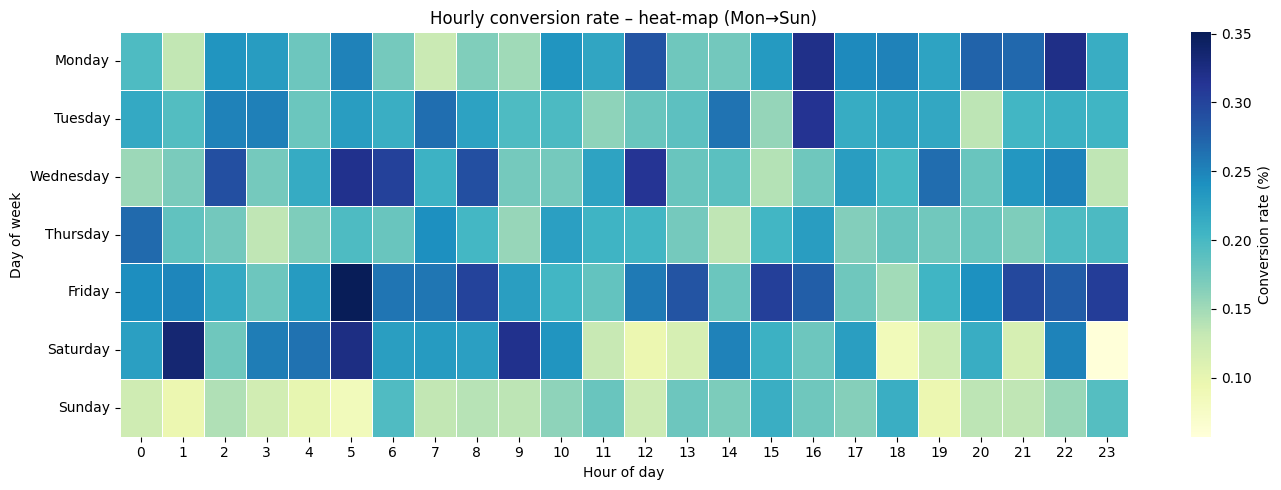

In [38]:
# Phase 3 – Extra visual: Hour-by-day conversion heat-map
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣  aggregate to a day-of-week × hour grid
grid = (
    df.groupby(['day_name', 'hour'])
      .agg(purchases=('is_purchase', 'sum'),
           events    =('event_name',  'count'))
      .reset_index()
)
grid['conv'] = (grid['purchases'] / grid['events'] * 100).round(3)

# ensure rows in calendar order (Mon→Sun)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']
pivot = (
    grid.pivot(index='day_name', columns='hour', values='conv')
        .reindex(day_order)
)

# 2️⃣  plot
plt.figure(figsize=(14,5))
sns.heatmap(pivot,
            cmap='YlGnBu', linewidths=.5,
            cbar_kws={'label':'Conversion rate (%)'})
plt.title('Hourly conversion rate – heat-map (Mon→Sun)')
plt.xlabel('Hour of day')
plt.ylabel('Day of week')
plt.tight_layout()
plt.show()


In [42]:
df.columns

Index(['event_date', 'event_name', 'user_pseudo_id', 'device_category',
       'operating_system', 'browser', 'country', 'city', 'source', 'medium',
       'campaign_name', 'transaction_id', 'purchase_revenue',
       'purchase_revenue_in_usd', 'total_item_quantity', 'event_timestamp',
       'is_purchase', 'hour', 'day_name', 'is_weekend'],
      dtype='object')

In [43]:
df.shape

(2151546, 20)

In [44]:
# ── EXPORT FOR POWER BI ──────────────────────────────
# Save the fully-cleaned, feature-enhanced table
# (make sure this cell runs AFTER all feature-engineering cells)

df.to_csv('merchandise_store_full_data.csv', index=False)
print('✅  CSV ready for Power BI:  merchandise_store_full_data.csv')


✅  CSV ready for Power BI:  merchandise_store_full_data.csv


In [45]:
!ls /content          # should list merchandise_store_full_data.csv


merchandise_store_full_data.csv  sample_data
